In [1]:
import requests
from bs4 import BeautifulSoup
import re
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Scrape chapters from Fandom
# -----------------------------
url = "https://harrypotter.fandom.com/wiki/Harry_Potter_and_the_Deathly_Hallows"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
content_div = soup.find("div", class_="mw-parser-output")

chapter_splits = []
current_chapter = None
in_plot_section = False

for elem in content_div.children:
    if elem.name == "h2":  # top-level heading
        heading_text = elem.get_text().strip()
        if "Plot" in heading_text:
            in_plot_section = True
            continue
        elif in_plot_section:
            # reached a new h2 after plot => stop
            break
    if not in_plot_section:
        continue

    if elem.name in ["h3", "h4"]:  # chapter headings
        text = elem.get_text().strip()
        if "Chapter" in text or "Epilogue" in text:
            if current_chapter:
                chapter_splits.append(current_chapter)
            current_chapter = text + "\n"
    elif elem.name == "p" and current_chapter:
        current_chapter += elem.get_text().strip() + "\n\n"

# Append last chapter
if current_chapter:
    chapter_splits.append(current_chapter)

print(f"Found {len(chapter_splits)} chapters. Example:")
print(chapter_splits[0][:500])

Found 37 chapters. Example:
Chapter 1: The Dark Lord Ascending[]
The seventh and final book begins with Voldemort and his Death Eaters having a meeting at Malfoy Manor. They are beginning to plan out how to kidnap Harry Potter during his evacuation from 4 Privet Drive when he will be vulnerable. After "borrowing" Lucius Malfoy's wand in order to annihilate Harry once and for all — Voldemort does so in a way that indicates Malfoy has no choice — Voldemort kills his captive, Charity Burbage (the Muggle Studies professor at H


In [2]:
# -----------------------------
# Step 2: Setup Hugging Face classifier
# -----------------------------
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)  # GPU
candidate_labels = ["dark", "hope"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [3]:
# -----------------------------
# Step 3: Helper: chunk text
# -----------------------------
def chunk_text(text, max_len=500):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_len):
        chunks.append(" ".join(words[i:i+max_len]))
    return chunks

In [4]:
# -----------------------------
# Step 4: Analyze darkness per chapter
# -----------------------------
chapter_scores = []

for chap_idx, chap in enumerate(chapter_splits, start=1):
    title = chap.split("\n")[0]
    # clean brackets / footnotes
    title = re.sub(r'\[\d*\]', '', title)

    text = chap
    print(f"Processing {title} ({chap_idx}/{len(chapter_splits)})...")

    chunks = chunk_text(text, max_len=500)

    chunk_scores = []
    for chunk in chunks:
        result = classifier(chunk, candidate_labels)
        score_dark = result["scores"][result["labels"].index("dark")]
        score_hope = result["scores"][result["labels"].index("hope")]
        darkness_score = score_dark - score_hope
        chunk_scores.append(darkness_score)

    avg_score = sum(chunk_scores) / len(chunk_scores)
    chapter_scores.append({"Chapter": title, "Darkness": avg_score})

Processing Chapter 1: The Dark Lord Ascending (1/37)...
Processing Chapter 2: In Memoriam (2/37)...
Processing Chapter 3: The Dursleys Departing (3/37)...
Processing Chapter 4: The Seven Potters (4/37)...
Processing Chapter 5: Fallen Warrior (5/37)...
Processing Chapter 6: The Ghoul in Pyjamas (6/37)...
Processing Chapter 7: The Will of Albus Dumbledore (7/37)...
Processing Chapter 8: The Wedding (8/37)...
Processing Chapter 9: A Place to Hide (9/37)...
Processing Chapter 10: Kreacher's Tale (10/37)...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processing Chapter 11: The Bribe (11/37)...
Processing Chapter 12: Magic is Might (12/37)...
Processing Chapter 13: The Muggle-Born Registration Commission (13/37)...
Processing Chapter 14: The Thief (14/37)...
Processing Chapter 15: The Goblin's Revenge (15/37)...
Processing Chapter 16: Godric's Hollow (16/37)...
Processing Chapter 17: Bathilda's Secret (17/37)...
Processing Chapter 18: The Life and Lies of Albus Dumbledore (18/37)...
Processing Chapter 19: The Silver Doe (19/37)...
Processing Chapter 20: Xenophilius Lovegood (20/37)...
Processing Chapter 21: The Tale of the Three Brothers (21/37)...
Processing Chapter 22: The Deathly Hallows (22/37)...
Processing Chapter 23: Malfoy Manor (23/37)...
Processing Chapter 24: The Wandmaker (24/37)...
Processing Chapter 25: Shell Cottage (25/37)...
Processing Chapter 26: Gringotts (26/37)...
Processing Chapter 27: The Final Hiding Place (27/37)...
Processing Chapter 28: The Missing Mirror (28/37)...
Processing Chapter 29: The Lost Diadem (

In [5]:
# -----------------------------
# Step 5: Create DataFrame
# -----------------------------
df = pd.DataFrame(chapter_scores)
df["Chapter_Num"] = df.index + 1  # preserve original order

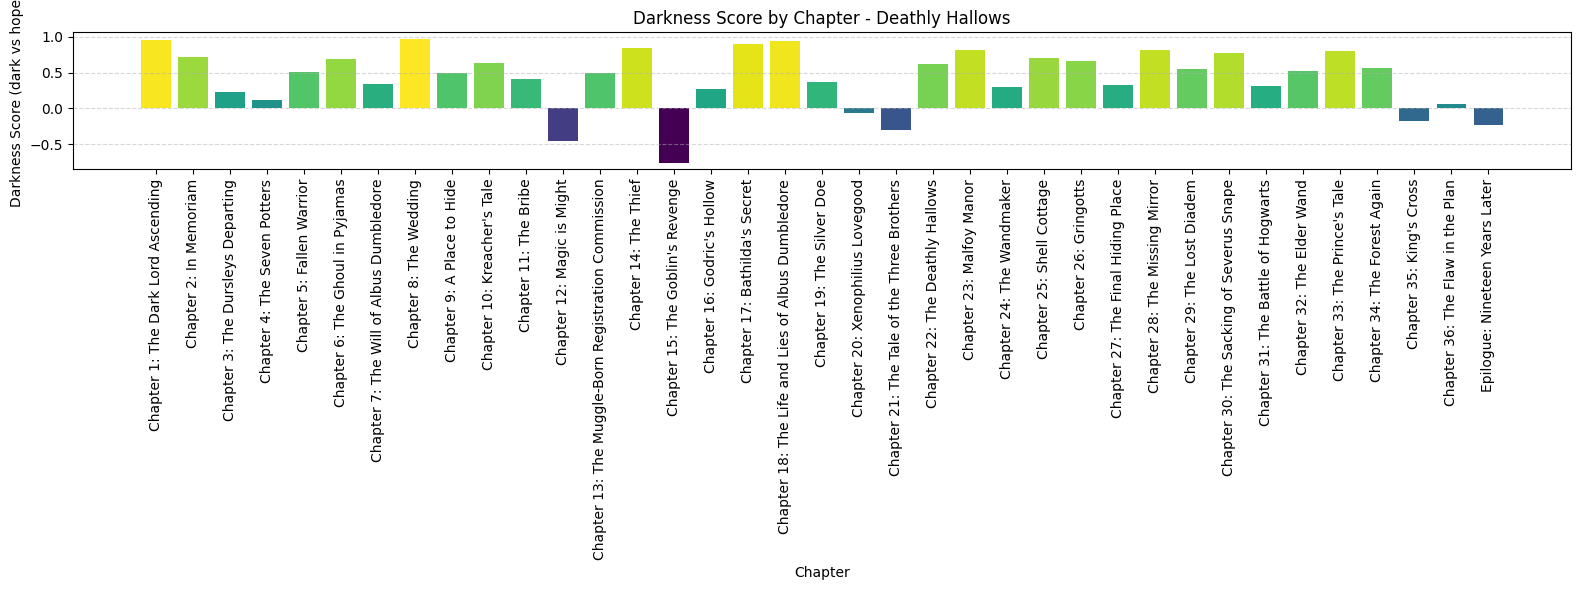

                                             Chapter  Darkness  Chapter_Num
0                             Chapter 8: The Wedding  0.978027            8
1                 Chapter 1: The Dark Lord Ascending  0.964018            1
2  Chapter 18: The Life and Lies of Albus Dumbledore  0.937447           18
3                      Chapter 17: Bathilda's Secret  0.907106           17
4                              Chapter 14: The Thief  0.844431           14
5                           Chapter 23: Malfoy Manor  0.819058           23
6                     Chapter 28: The Missing Mirror  0.818385           28
7                      Chapter 33: The Prince's Tale  0.807717           33
8           Chapter 30: The Sacking of Severus Snape  0.775861           30
9                             Chapter 2: In Memoriam  0.718342            2


In [6]:
# -----------------------------
# Step 6: Plot darkness over chapters
# -----------------------------
plt.figure(figsize=(16,6))
bars = plt.bar(df["Chapter_Num"], df["Darkness"], color=plt.cm.viridis((df["Darkness"] - df["Darkness"].min()) / (df["Darkness"].max() - df["Darkness"].min())))
plt.xticks(df["Chapter_Num"], df["Chapter"], rotation=90)
plt.xlabel("Chapter")
plt.ylabel("Darkness Score (dark vs hope)")
plt.title("Darkness Score by Chapter - Deathly Hallows")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# Optional: Sort by darkness
# -----------------------------
df_sorted = df.sort_values("Darkness", ascending=False).reset_index(drop=True)
print(df_sorted.head(10))